## 1. Loading libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('..\data\WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2. Feature Engineering

In [3]:
df.drop('customerID', axis=1, inplace=True) 

In [4]:
print(df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)

22


In [5]:
df["SeniorCitizen"]= df["SeniorCitizen"].map({0: "No", 1: "Yes"})

In [6]:
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)
df = df.reset_index(drop=True)

In [7]:
def encode_features(dataframe):

    df = dataframe.copy()

    services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                'TechSupport', 'StreamingTV', 'StreamingMovies']

    df_services = df[services].apply(lambda col: col.map(lambda x: 1 if x == 'Yes' else 0))
    df['InternetServicesUsed'] = df_services.sum(axis=1)

    # binary_columns
    binary_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
    for col in binary_cols:
        df[col] = df[col].map({'Yes': 1, 'No': 0, 'Female': 0, 'Male': 1})

    # InternetService_column
    # df['HasInternet'] = df['InternetService'].apply(lambda x: 0 if x == 'No' else 1)
    df['DLS'] = df['InternetService'].apply(lambda x: 1 if x == 'DSL' else 0)
    df['Fiber'] = df['InternetService'].apply(lambda x: 1 if x == 'Fiber optic' else 0)
    df = df.drop(columns=['InternetService'])

    # triple_columns
    triple_col = [
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
        'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'
    ]
    for column in triple_col:
        df[f"{column}_y"] = df[column].apply(lambda x: 1 if x == 'Yes' else 0)
        # df[f"{column}_n"] = df[column].apply(lambda x: 1 if x == 'No' else 0)
        df = df.drop(columns=[column])

    #categorical_columns
    cat_cols = ['Contract', 'PaymentMethod']
    df = pd.get_dummies(df, columns=cat_cols)
    df = df.astype({col: int for col in df.select_dtypes('bool').columns})

    return df   

In [8]:
encoded_df = encode_features(df)

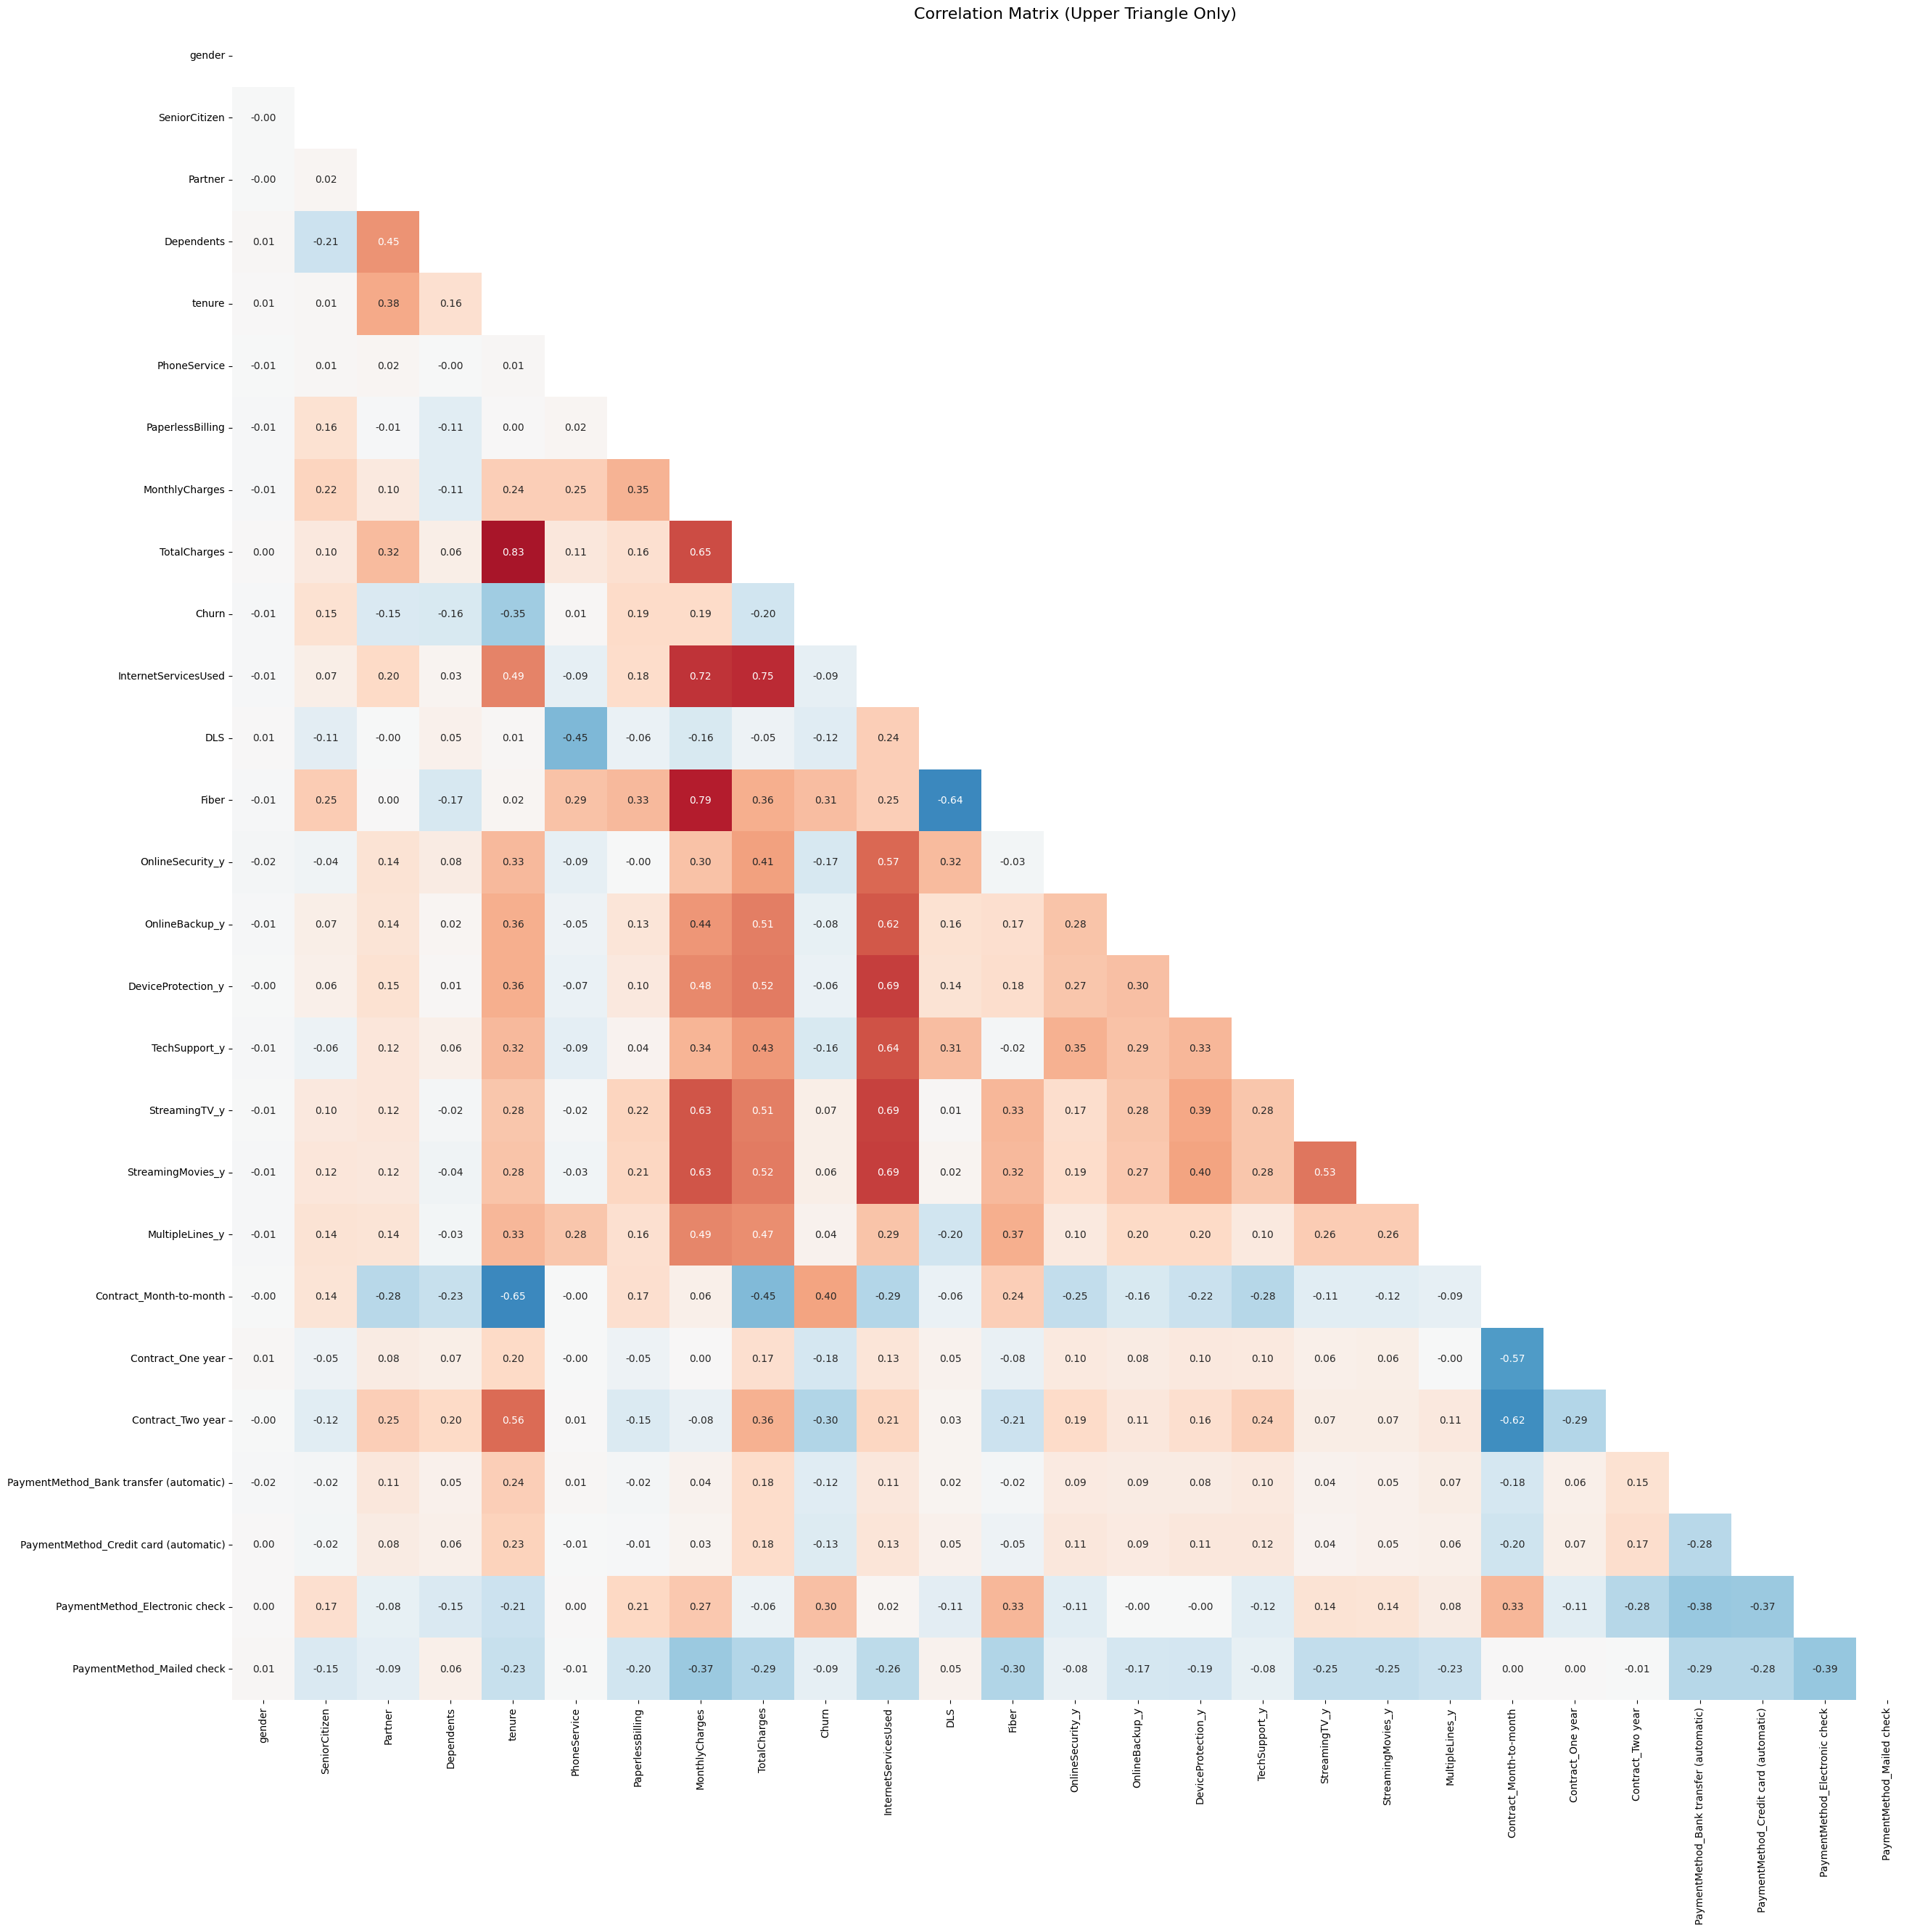

In [9]:
corr = encoded_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(30, 30))
sns.heatmap(corr, mask=mask, cmap='RdBu_r', vmin=-1, vmax=1, annot=True, center=0, fmt=".2f", cbar=False)
plt.title("Correlation Matrix (Upper Triangle Only)", fontsize=16)
plt.show()


In [10]:
churn_corr = np.abs(encoded_df.corr())['Churn']
churn_corr = churn_corr.sort_values()
churn_corr.head(10)

gender                                     0.008694
PhoneService                               0.011072
MultipleLines_y                            0.041888
StreamingMovies_y                          0.062670
DeviceProtection_y                         0.064978
StreamingTV_y                              0.065058
OnlineBackup_y                             0.081145
InternetServicesUsed                       0.086079
PaymentMethod_Mailed check                 0.091649
PaymentMethod_Bank transfer (automatic)    0.117442
Name: Churn, dtype: float64

In [11]:
corr_matrix = encoded_df.corr()
corr_abs = corr_matrix.abs()
np.fill_diagonal(corr_abs.values, 0)
highest_corr = corr_abs.unstack().sort_values(ascending=False)
highest_corr.head(20).iloc[::2]

tenure                TotalCharges               0.825293
Fiber                 MonthlyCharges             0.787169
InternetServicesUsed  TotalCharges               0.745241
                      MonthlyCharges             0.724477
                      DeviceProtection_y         0.692463
StreamingMovies_y     InternetServicesUsed       0.692423
StreamingTV_y         InternetServicesUsed       0.687265
MonthlyCharges        TotalCharges               0.650540
tenure                Contract_Month-to-month    0.648215
DLS                   Fiber                      0.643450
dtype: float64

In [12]:
df.drop('gender', axis=1, inplace=True)
encoded_df.drop('gender', axis=1, inplace=True)

In [13]:
encoded_df.columns

Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'InternetServicesUsed', 'DLS', 'Fiber', 'OnlineSecurity_y',
       'OnlineBackup_y', 'DeviceProtection_y', 'TechSupport_y',
       'StreamingTV_y', 'StreamingMovies_y', 'MultipleLines_y',
       'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [14]:
def encode_features(dataframe):

    df = dataframe.copy()

    services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
            'TechSupport', 'StreamingTV', 'StreamingMovies']

    df_services = df[services].apply(lambda col: col.map(lambda x: 1 if x == 'Yes' else 0))
    df['InternetServicesUsed'] = df_services.sum(axis=1)

    # binary_columns
    binary_cols = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
    for col in binary_cols:
        df[col] = df[col].map({'Yes': 1, 'No': 0, 'Female': 0, 'Male': 1})

    # InternetService_column
    df['DLS'] = df['InternetService'].apply(lambda x: 1 if x == 'DSL' else 0)
    df['Fiber'] = df['InternetService'].apply(lambda x: 1 if x == 'Fiber optic' else 0)
    df = df.drop(columns=['InternetService'])

    # triple_columns
    triple_col = [
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
        'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'
    ]
    for column in triple_col:
        df[f"{column}_y"] = df[column].apply(lambda x: 1 if x == 'Yes' else 0)
        df = df.drop(columns=[column])

    #categorical_columns
    cat_cols = ['Contract', 'PaymentMethod']
    df = pd.get_dummies(df, columns=cat_cols)
    df = df.astype({col: int for col in df.select_dtypes('bool').columns})

    return df   

In [15]:
X = df.drop(columns=['Churn'])
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [16]:
def undersampling_data(dataframe_X, series_y):

    X_train_resampled = dataframe_X.copy()
    y_train_resampled = series_y.copy()

    dataframe_X = encode_features(dataframe_X)
    series_y = series_y.map({'No': 0, 'Yes': 1})
    
    pca = PCA(n_components=2)
    X_pca_before = pca.fit_transform(dataframe_X)

    enn = EditedNearestNeighbours(kind_sel = 'mode', n_neighbors=3)
    X_enn, y_enn = enn.fit_resample(dataframe_X, series_y)
    kept_indices = enn.sample_indices_
    X_train_resampled = X_train_resampled.iloc[kept_indices].reset_index(drop=True)
    y_train_resampled = y_train_resampled.iloc[kept_indices].reset_index(drop=True)
    
    X_pca_after = pca.transform(X_enn)

    plt.figure(figsize=(15, 4))
    cmap = ListedColormap(['#336699', '#CC3333'])
    plt.subplot(1, 2, 1)
    plt.title("Before ENN")
    plt.scatter(X_pca_before[:, 0], X_pca_before[:, 1], c=series_y, cmap=cmap, alpha=0.5)
    plt.subplot(1, 2, 2)
    plt.title("After ENN")
    plt.scatter(X_pca_after[:, 0], X_pca_after[:, 1], c=y_enn, cmap=cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()

    print("Before ENN:")
    print(series_y.map({0: 'No', 1: 'Yes'}).value_counts())

    print("After ENN:")
    print(y_enn.map({0: 'No', 1: 'Yes'}).value_counts())

    return X_train_resampled, y_train_resampled

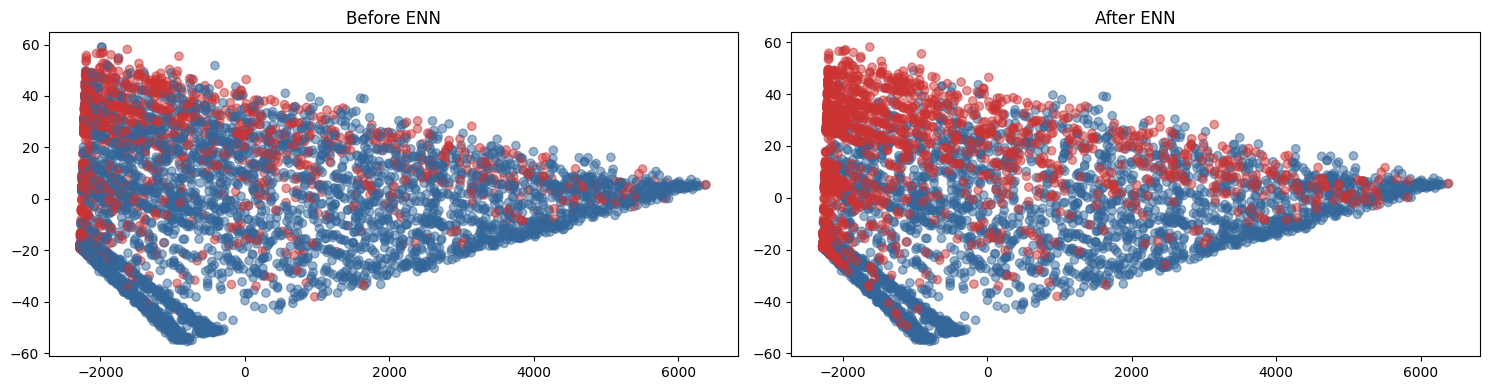

Before ENN:
Churn
No     4122
Yes    1486
Name: count, dtype: int64
After ENN:
Churn
No     3530
Yes    1486
Name: count, dtype: int64


In [17]:
X_train_resampled, y_train_resampled = undersampling_data(X_train, y_train)

In [18]:
def oversampling_data(dataframe_X, series_y):
    categorical_columns = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
                       'MultipleLines', 'PaperlessBilling', 'InternetService',
                       'OnlineSecurity','OnlineBackup', 'DeviceProtection',
                       'TechSupport','StreamingTV', 'StreamingMovies',
                       'Contract', 'PaymentMethod']
    for col in categorical_columns:
        dataframe_X[col] = dataframe_X[col].astype('category')

    cat_idx = [dataframe_X.columns.get_loc(col) for col in categorical_columns]
    smote_nc = SMOTENC(categorical_features=cat_idx, random_state=42)
    X_resampled, y_resampled = smote_nc.fit_resample(dataframe_X, series_y)

    def remove_logical_conflicts(X, y, dependency_col, service_col, service_values, invalid_vals_by_service):
        for service_val in service_values:
            mask_service = X[service_col] == service_val
            invalid_vals = invalid_vals_by_service[service_val]
            mask_conflict = mask_service & X[dependency_col].apply(
                lambda row: any(val in invalid_vals for val in row), axis=1)
            X = X[~mask_conflict].reset_index(drop=True)
            y = y[~mask_conflict].reset_index(drop=True)
        return X, y

    internetService_dependent_col = ['StreamingMovies', 'StreamingTV', 'TechSupport', 'DeviceProtection', 'OnlineBackup', 'OnlineSecurity']
    phoneService_dependent_col = ['MultipleLines']

    internet_invalids = {
        'No': ['Yes', 'No'],
        'DSL': ['No internet service'],
        'Fiber optic': ['No internet service']
    }
    phone_invalids = {
        'No': ['Yes', 'No'],
        'Yes': ['No phone service']
    }

    X_resampled, y_resampled = remove_logical_conflicts(
        X_resampled, y_resampled, internetService_dependent_col, 'InternetService',
        ['No', 'DSL', 'Fiber optic'], internet_invalids
    )

    X_resampled, y_resampled = remove_logical_conflicts(
        X_resampled, y_resampled, phoneService_dependent_col, 'PhoneService',
        ['No', 'Yes'], phone_invalids
    )

    

    print("Before SMOTE:")
    print(series_y.value_counts())
    print("After SMOTE:")
    print(y_resampled.value_counts())

    return X_resampled, y_resampled
    

In [19]:
X_train_resampled, y_train_resampled = oversampling_data(X_train_resampled, y_train_resampled)

Before SMOTE:
Churn
No     3530
Yes    1486
Name: count, dtype: int64
After SMOTE:
Churn
No     3530
Yes    3519
Name: count, dtype: int64


In [20]:
def plot_distribution_comparison(X_before, X_after):
    columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
    plt.figure(figsize=(18, 5))

    for i, col in enumerate(columns):
        plt.subplot(1, 3, i+1)
        sns.histplot(X_before[col], bins=30, color='skyblue', label='Before', kde=True, stat='density', alpha=0.5)
        sns.histplot(X_after[col], bins=30, color='salmon', label='After', kde=True, stat='density', alpha=0.5)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.legend()

    sns.despine()
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

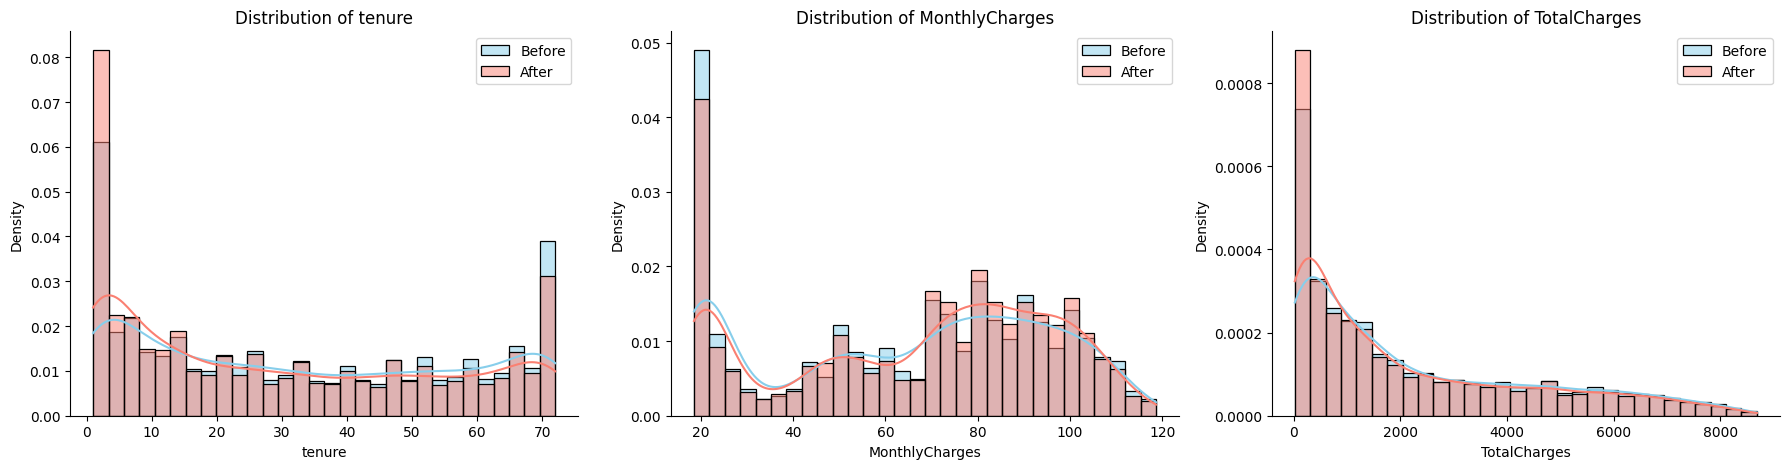

In [21]:
plot_distribution_comparison(X_train, X_train_resampled)

In [22]:
X_train_resampled = encode_features(X_train_resampled)
X_test = encode_features(X_test)
y_train_resampled = y_train_resampled.map({'No': 0, 'Yes': 1})
y_test = y_test.map({'No': 0, 'Yes': 1})

In [23]:
scaler = MinMaxScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)
X_train_resampled = pd.DataFrame(X_train_resampled)
X_test = pd.DataFrame(X_test)

In [24]:
X_train_resampled

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,1.0,0.0,0.901408,1.0,1.0,0.890110,0.815145,0.833333,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.760563,1.0,1.0,0.717782,0.586239,0.333333,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.014085,1.0,1.0,0.357642,0.011337,0.166667,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,1.0,0.845070,1.0,0.0,0.412088,0.418036,0.333333,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.830986,1.0,1.0,0.811688,0.688547,0.500000,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7044,0.0,0.0,0.0,0.000000,1.0,1.0,0.371508,0.004262,0.166667,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7045,0.0,0.0,0.0,0.366197,1.0,1.0,0.628475,0.258786,0.333333,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7046,0.0,0.0,0.0,0.887324,1.0,1.0,0.863111,0.793897,0.833333,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
7047,0.0,0.0,0.0,0.197183,1.0,1.0,0.629134,0.149175,0.166667,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
